# Simulator

The code below simulates our system as modeled in Milestone 0. The first code block contains functions which evaluate the net force on the permanent magnet and the effect this has on its motion. Details on the individual functions can be found in the docstrings. 

We validated the system and the controller in two ways. First, we turned the controller off and measured the position over time of the permanent magnet in free fall. We compared this to an analytical solution (no drag) of a free falling object and got results which matched closely. Turning our controller on allows us to see how the controller influences the behavior of the system as well. As we modeled our system, we have two poles on the real axes equidistant from the imaginary axis. With a proportional gain only, the best outcome we could possibly achieve is a marginally stable system, and this expectation matched our result. While we have some rough estimates for physical parameters, we are hoping to clarify these once we start running simulations on the master simulator. 

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib notebook

plt.style.use('ggplot')

def get_force(force, voltage, pos, cg, R):
    '''
    Returns the net force applied to the permanent magnet

    force: force array
    voltage: voltage array
    pos: position array
    cg: force constant
    R: resistance of solenoid
    '''
    new = m*g - cg * voltage[-1] / (pos[-1]**2) / R
    return np.append(np.delete(force, 0), new)

def get_acceleration(accel, force, m):
    '''
    Returns the velocity of the permanent magnet

    accel: acceeration array
    force: force array
    m: mass
    '''
    new = force[-1]/m
    return np.append(np.delete(accel, 0), new)

def get_velocity(vel, accel, delta_t):
    '''
    Returns the velocity of the permanent magnet

    vel: velocity array
    accel: acceleration array
    '''
    new = accel[-1]*delta_t + vel[-1]
    return np.append(np.delete(vel, 0), new)

def get_position(pos, vel, delta_t):
    '''
    Returns the position of the permanent magnet

    pos: position array
    vel: velocity array
    '''
    new = vel[-1]*delta_t + pos[-1]
    return np.append(np.delete(pos, 0), new)

def get_time(time, delta_t):
    '''
    Returns the time of our system as an array.

    time: time array of system
    delta_t: time step size
    '''
    new = time[-1] + delta_t
    return np.append(np.delete(time, 0), new)

def get_voltage(voltage, target, pos, kp, kd, ki, i_gain, delta_t):
    '''
    Returns the output of the controller as an array of voltages.
    This function represents the summation and control block in our diagram.
    
    Returns i_gain: integral gain

    target: input value to our system
    pos: position array of magnent
    kp: proportionality constant
    kd: derivative constant
    ki: integral constant
    i_gain: integral gain
    '''
    error = (pos[-1] - target)
    dpos = (pos[-1] - pos[-2])/delta_t
    
    p_gain = kp*error
    d_gain = kd*dpos
    i_gain += ki*error*delta_t
    
    new = p_gain + d_gain + i_gain
    return np.append(np.delete(voltage, 0), new), i_gain

def get_measured_position(mpos, voltage, pos, cv, cm):
    '''
    Retuns the output of the hall effect sensor mapped
    with a function to generate measured distance.
    
    sensor: sensor value array
    voltage: voltage across solenoid
    pos: position of permanent magnet
    
    cv: solenoid coefficient
    cm: permanent magnet coefficient
    '''
    new = cv * voltage[-1] + cm / (pos[-1]**2)
    
    ## magic circuit
    output = np.sqrt(cm / (new - cv * voltage[-1]))
    
    return np.append(np.delete(mpos, 0), output)

### Boring Static Plotting

#### Defining Constants
The constants we use in our functions are located below. Based off of the video of the system we are assuming the mass of the permanent magnet is 25g and the distance from the magnet to the solenoid is 1cm. The resistance of the solenoid is based off data from a 12V solenoid found on [Adafruit](https://www.adafruit.com/product/1512). The coefficients $c_v$ and $c_m$ which describe the sensor are going to remain equal to one because we are currently assuming $H(s) = 1$ and we have a function that outputs the exact position from the sensor. 

#### Calculating C_g
The coefficient $c_g$ is related to $x_i$ and $v_i$ with the following equation calculated in milestone 0:

$$x_i = \sqrt{\frac{2 c_g v_i}{mg }}$$

Assuming that the system in the video was trying to hold the magnet at a fixed position in the middle of the controller's voltage and that the voltage range is equal to $12V$ (a pretty standard voltage power supply for small solenoids), we can assume that $V_i = 6V$. This means $c_g$ can be calculated to be $2.04375e-06$


<IPython.core.display.Javascript object>


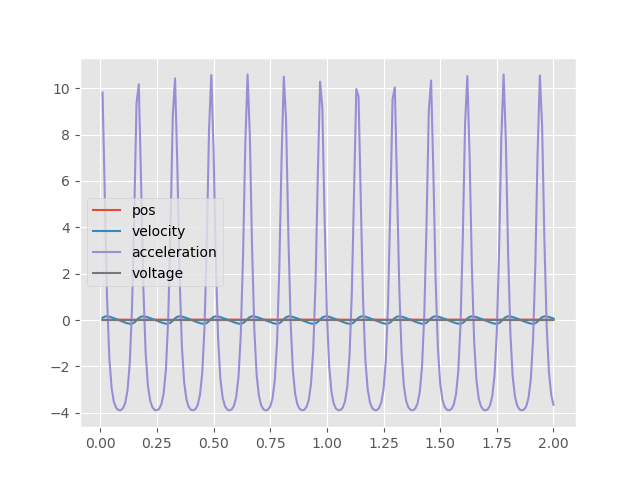

In [81]:
plt.style.use('ggplot')
fig1, ax1 = plt.subplots()

#definition of constants
g = 9.81 #gravity
m = .025   #mass 
cm = 1   #hall effect sensor mass coefficient
cv = 1   #hall effect sensor solenoid coefficient
cg = 1 #2.04375e-06   #force of solenoid coefficient
R  = 18   #resistance of solenoid

#definition of simulation variables
size = 200   #number of points to plot
delta_t = .01 #time step between points
kp = .25       #proportional constant
kd = 0       #derivative constant
ki = 0       #integral constant
i_gain  = 0  #gain of integral part of controller
xi = .01      #starting position

#definition of input signal
target = .01

#definition of state arrays
force = np.zeros(size)        #force from solenoid
voltage = np.zeros(size)      #voltage across solenoid
pos = np.ones(size)*xi        #position of permanent magnet
vel = np.zeros(size)          #velocity of permanent magnet
accel = np.ones(size) * g        #acceleration of permanent magnet
time = np.zeros(size)         #time
measured_pos = np.ones(size) * xi #measured position from sensor

for i in range(size):
    measured_pos = get_measured_position(measured_pos, voltage, pos, cv, cm)
    voltage, i_gain = get_voltage(voltage, target, measured_pos, kp, kd, ki, i_gain, delta_t)
    force = get_force(force, voltage, pos, cg, R)
    accel = get_acceleration(accel, force, m)
    vel = get_velocity(vel, accel, delta_t)
    pos = get_position(pos, vel, delta_t)
    time = get_time(time, delta_t)
    
plt.plot(time, pos, label="pos")
plt.plot(time, vel, label="velocity")
plt.plot(time, accel, label="acceleration")
plt.plot(time, voltage, label="voltage")
# plt.plot(time, accel)
plt.legend()
# plt.ylim(-5, 5)
plt.show()

#### Live Plotting

<IPython.core.display.Javascript object>


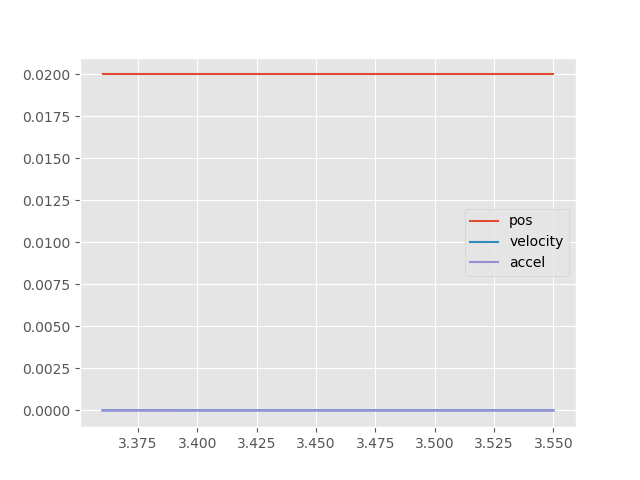

KeyboardInterrupt: 

In [91]:


fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

#definition of constants
g = 9.81 #gravity
m = .025   #mass 
cm = 1   #hall effect sensor mass coefficient
cv = 1   #hall effect sensor solenoid coefficient
cg = 1 #2.04375e-06   #force of solenoid coefficient
R  = 18   #resistance of solenoid

#definition of simulation variables
size = 20   #number of points to plot
delta_t = .01 #time step between points
kp = .5       #proportional constant
kd = .01       #derivative constant
ki = 1      #integral constant
i_gain  = 0  #gain of integral part of controller
xi = .05      #starting position

#definition of input signal
target = .02

#definition of state arrays
force = np.zeros(size)        #force from solenoid
voltage = np.zeros(size)      #voltage across solenoid
pos = np.ones(size)*xi        #position of permanent magnet
vel = np.zeros(size)          #velocity of permanent magnet
accel = np.ones(size) * g        #acceleration of permanent magnet
time = np.zeros(size)         #time
measured_pos = np.ones(size) * xi #measured position from sensor

while True:
    measured_pos = get_measured_position(measured_pos, voltage, pos, cv, cm)
    voltage, i_gain = get_voltage(voltage, target, measured_pos, kp, kd, ki, i_gain, delta_t)
    force = get_force(force, voltage, pos, cg, R)
    accel = get_acceleration(accel, force, m)
    vel = get_velocity(vel, accel, delta_t)
    pos = get_position(pos, vel, delta_t)
    time = get_time(time, delta_t)
    
    ax.clear()
    ax.plot(time, pos, label="pos")
    ax.plot(time, vel, label="velocity")
    ax.plot(time, accel, label="accel")
#     ax.plot(time, measured_pos, label="m pos")
#     ax.plot(time, target)
#     ax.plot(time, voltage)
    ax.legend()
    fig.canvas.draw()
    

<IPython.core.display.Javascript object>


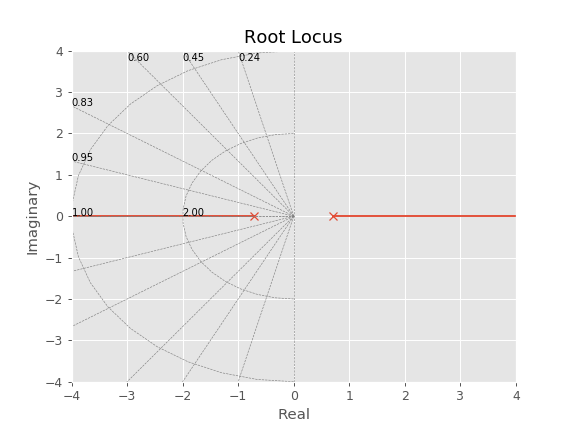

In [60]:
import numpy as np
from matplotlib import pyplot as plt 
import control

fig1, ax1 = plt.subplots()

# 2a
G = control.TransferFunction((-1), (2, 0, -1))

rlist, klist = control.rlocus(G, kvect=np.linspace(0, 20, num=100), plot=True, xlim=(-4,4), ylim=(-4, 4))